In [1]:
import torch
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d
from math import ceil

# uint i to binary bin(i,q_bit): max(i)=15., q_bit=4
def int_to_binary(numbers):
    binlist = np.array([f'{int(num):04b}' for num in numbers])
    concatenated_string = ''.join(binlist)
    sequence = np.array(list(concatenated_string), dtype=int)
    return sequence

# uint i to binary bin(i), random spikes (1) of total number i in 255 time windows
def int_to_binary_random(numbers):
    binary_arrays = [(np.arange(15) < val).astype(int) for val in numbers]
    for binary_array in binary_arrays:
        np.random.shuffle(binary_array)
    sequence = np.hstack(binary_arrays)
    return sequence

# smooth the spike array
def smooth_sequence(arr):
    n = len(arr)
    smoothed_arr = arr.copy()
    
    start_indices = np.concatenate(([0], np.where(np.diff(arr) != 0)[0] + 1))
    end_indices = np.concatenate((start_indices[1:], [n]))
    
    for start, end in zip(start_indices, end_indices):
        if end - start > 2:
            x = np.arange(start, end)
            y = arr[start:end]
            try:
                f = interp1d(x, y, kind='cubic')
                smoothed_arr[start:end] = f(x)
            except ValueError:
                f = interp1d(x, y, kind='linear')
                smoothed_arr[start:end] = f(x)
        elif end - start == 2:
            x = np.arange(start, end)
            y = arr[start:end]
            f = interp1d(x, y, kind='linear')
            smoothed_arr[start:end] = f(x)
        else:
            smoothed_arr[start:end] = arr[start:end]
    
    smoothed_arr = np.array(smoothed_arr)
    
    return smoothed_arr

# Input: a spike train (0/1); Output: the KS Entropy matrix of the spike train
def HKS_calculation(spike_train, smooth = False):
    # MLE of lambda in Posisson distribution equals to the sample average
    spike_numlist = np.cumsum(spike_train)
    lambda_mle_list = spike_numlist
    if smooth == True:
        lambda_mle_list = smooth_sequence(lambda_mle_list)

    t_max = len(spike_train)
    r_max = int(1.2*np.max(lambda_mle_list))
    tau_max = ceil(0.2*t_max)
    time_windows = 0.2

    HKS_matrix = np.zeros((t_max-tau_max, tau_max))
    prob_from_initial = np.zeros((t_max-tau_max, r_max))
    for t in range(t_max-tau_max):
        if t == 0:
            prob_from_initial[t, 0] = 1
        else:
            prob_from_initial[t, 0] = np.exp(-lambda_mle_list[t-1])
            for r in range(r_max-1):
                prob_from_initial[t, r+1] = prob_from_initial[t, r]*lambda_mle_list[t-1]/(r+1)

    for t in range(t_max-tau_max):
        prob_from_t = np.zeros((tau_max, r_max))
        for tau in range(tau_max): # 注意应当设置tau>=1，所以后续使用tau计算时，应考虑tau=tau+1的问题
            if t == 0:
                lam = lambda_mle_list[t+tau]
            else:
                lam = lambda_mle_list[t+tau] - lambda_mle_list[t-1]
            prob_from_t[tau, 0] = np.exp(-lam)
            for r in range(r_max-1):
                prob_from_t[tau, r+1] = prob_from_t[tau, r]*lam/(r+1)
            for i in range(r_max):
                for j in range(i+1, r_max):
                    if (prob_from_t[tau, j-i]*prob_from_initial[t, i]) > 0:
                        HKS_matrix[t][tau] += prob_from_initial[t, i]*prob_from_t[tau, j-i]*prob_from_initial[t, i]*np.log(prob_from_t[tau, j-i]*prob_from_initial[t, i])
            HKS_matrix[t][tau] = -1*HKS_matrix[t][tau]/(tau+1)
        # print('HKS matrix ['+str(t+1)+'] done. (end at '+str(t_max-tau_max)+ ')') # 这句话用来提示进度，有点吵可以注释掉
        
    return HKS_matrix


In [3]:
# For task winogrande_true, word_id 0, layer att.key.l8, sentence 4, neuron 483: token sequence all 0.
# For task winogrande_true, word_id 0, layer att.key.l8, sentence 1, neuron 483: token sequence all 0.
# For task winogrande_true, word_id 0, layer att.key.l8, sentence 6, neuron 483: token sequence all 0.
# For task winogrande_true, word_id 0, layer att.key.l8, sentence 11, neuron 483: token sequence all 0.
# For task winogrande_true, word_id 0, layer att.key.l8, sentence 17, neuron 483: token sequence all 0.
# For task winogrande_true, word_id 0, layer att.key.l10, sentence 10, neuron 645: token sequence all 0.
# For task winogrande_true, word_id 0, layer att.key.l10, sentence 17, neuron 645: token sequence all 0.
# For task winogrande_true, word_id 0, layer att.key.l10, sentence 18, neuron 645: token sequence all 0.
# For task winogrande_true, word_id 0, layer att.key.l10, sentence 14, neuron 645: token sequence all 0.
# For task winogrande_true, word_id 0, layer att.key.l10, sentence 12, neuron 645: token sequence all 0.
# For task winogrande_true, word_id 0, layer att.key.l10, sentence 13, neuron 645: token sequence all 0.
# For task winogrande_true, word_id 0, layer att.key.l10, sentence 16, neuron 645: token sequence all 0.
# For task winogrande_true, word_id 0, layer att.key.l10, sentence 19, neuron 645: token sequence all 0.
# For task winogrande_true, word_id 0, layer att.key.l11, sentence 5, neuron 41: token sequence all 0.

# 计算KS熵矩阵的demo (动力学分析)，使用了一层中随机抽样30神经元数据进行演示

layer_name_list = [
    'att.key.l0','att.key.l1','att.key.l2','att.key.l3','att.key.l4','att.key.l5',
    'att.key.l6','att.key.l7','att.key.l8','att.key.l9','att.key.l10','att.key.l11',
    'att.value.l0','att.value.l1','att.value.l2','att.value.l3','att.value.l4','att.value.l5',
    'att.value.l6','att.value.l7','att.value.l8','att.value.l9','att.value.l10','att.value.l11',
    'att.receptance.l0','att.receptance.l1','att.receptance.l2','att.receptance.l3','att.receptance.l4','att.receptance.l5',
    'att.receptance.l6','att.receptance.l7','att.receptance.l8','att.receptance.l9','att.receptance.l10','att.receptance.l11',
    'att.sigmoid.l0','att.sigmoid.l1','att.sigmoid.l2','att.sigmoid.l3','att.sigmoid.l4','att.sigmoid.l5',
    'att.sigmoid.l6','att.sigmoid.l7','att.sigmoid.l8','att.sigmoid.l9','att.sigmoid.l10','att.sigmoid.l11',
    
    'ffn.key.l0','ffn.key.l1','ffn.key.l2','ffn.key.l3','ffn.key.l4','ffn.key.l5',
    'ffn.key.l6','ffn.key.l7','ffn.key.l8','ffn.key.l9','ffn.key.l10','ffn.key.l11',
    'ffn.value.l0','ffn.value.l1','ffn.value.l2','ffn.value.l3','ffn.value.l4','ffn.value.l5',
    'ffn.value.l6','ffn.value.l7','ffn.value.l8','ffn.value.l9','ffn.value.l10','ffn.value.l11',
    'ffn.receptance.l0','ffn.receptance.l1','ffn.receptance.l2','ffn.receptance.l3','ffn.receptance.l4','ffn.receptance.l5',
    'ffn.receptance.l6','ffn.receptance.l7','ffn.receptance.l8','ffn.receptance.l9','ffn.receptance.l10','ffn.receptance.l11',
    'ffn.sigmoid.l0','ffn.sigmoid.l1','ffn.sigmoid.l2','ffn.sigmoid.l3','ffn.sigmoid.l4','ffn.sigmoid.l5',
    'ffn.sigmoid.l6','ffn.sigmoid.l7','ffn.sigmoid.l8','ffn.sigmoid.l9','ffn.sigmoid.l10','ffn.sigmoid.l11',
    
    'block.ln1.l0','block.ln1.l1','block.ln1.l2','block.ln1.l3','block.ln1.l4','block.ln1.l5',
    'block.ln1.l6','block.ln1.l7','block.ln1.l8','block.ln1.l9','block.ln1.l10','block.ln1.l11',
    'block.ln2.l0','block.ln2.l1','block.ln2.l2','block.ln2.l3','block.ln2.l4','block.ln2.l5',
    'block.ln2.l6','block.ln2.l7','block.ln2.l8','block.ln2.l9','block.ln2.l10','block.ln2.l11',

    'quant','block.ln0','head'
]

# 这下面在生成文件路径读取文件
# 四个task的神经元id是一样的可以合并
task_name = 'winogrande_true'
# 如果task_name in ['winogrande_true','winogrande_false'] 则 word_id in['0','1']（winogrande数据的输出生成2个单词,最后一个单词为休止符）
# 如果task_name in ['arc_easy_true','arc_easy_false'] 则 word_id in['0','1','2','3']（arc_easy数据的输出生成4个单词,最后一个单词为休止符）
word_id = '0'

layer_name = 'att.key.l10'
paths = glob.glob(os.path.join(f"/nfs/xuhan/xyh/data/data_06_04/int4/{task_name}", f'*doc_id_*_{word_id}.{layer_name}.0.pth'))

# data = 句子*上下文长度*神经元
data = np.squeeze(np.array([torch.load(path) for path in paths]))

print(data[:,:,645])


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [2]:
# 计算KS熵矩阵的demo (动力学分析)，使用了一层中随机抽样30神经元数据进行演示

layer_name_list = [
    'att.key.l0','att.key.l1','att.key.l2','att.key.l3','att.key.l4','att.key.l5',
    'att.key.l6','att.key.l7','att.key.l8','att.key.l9','att.key.l10','att.key.l11',
    'att.value.l0','att.value.l1','att.value.l2','att.value.l3','att.value.l4','att.value.l5',
    'att.value.l6','att.value.l7','att.value.l8','att.value.l9','att.value.l10','att.value.l11',
    'att.receptance.l0','att.receptance.l1','att.receptance.l2','att.receptance.l3','att.receptance.l4','att.receptance.l5',
    'att.receptance.l6','att.receptance.l7','att.receptance.l8','att.receptance.l9','att.receptance.l10','att.receptance.l11',
    'att.sigmoid.l0','att.sigmoid.l1','att.sigmoid.l2','att.sigmoid.l3','att.sigmoid.l4','att.sigmoid.l5',
    'att.sigmoid.l6','att.sigmoid.l7','att.sigmoid.l8','att.sigmoid.l9','att.sigmoid.l10','att.sigmoid.l11',
    
    'ffn.key.l0','ffn.key.l1','ffn.key.l2','ffn.key.l3','ffn.key.l4','ffn.key.l5',
    'ffn.key.l6','ffn.key.l7','ffn.key.l8','ffn.key.l9','ffn.key.l10','ffn.key.l11',
    'ffn.value.l0','ffn.value.l1','ffn.value.l2','ffn.value.l3','ffn.value.l4','ffn.value.l5',
    'ffn.value.l6','ffn.value.l7','ffn.value.l8','ffn.value.l9','ffn.value.l10','ffn.value.l11',
    'ffn.receptance.l0','ffn.receptance.l1','ffn.receptance.l2','ffn.receptance.l3','ffn.receptance.l4','ffn.receptance.l5',
    'ffn.receptance.l6','ffn.receptance.l7','ffn.receptance.l8','ffn.receptance.l9','ffn.receptance.l10','ffn.receptance.l11',
    'ffn.sigmoid.l0','ffn.sigmoid.l1','ffn.sigmoid.l2','ffn.sigmoid.l3','ffn.sigmoid.l4','ffn.sigmoid.l5',
    'ffn.sigmoid.l6','ffn.sigmoid.l7','ffn.sigmoid.l8','ffn.sigmoid.l9','ffn.sigmoid.l10','ffn.sigmoid.l11',
    
    'block.ln1.l0','block.ln1.l1','block.ln1.l2','block.ln1.l3','block.ln1.l4','block.ln1.l5',
    'block.ln1.l6','block.ln1.l7','block.ln1.l8','block.ln1.l9','block.ln1.l10','block.ln1.l11',
    'block.ln2.l0','block.ln2.l1','block.ln2.l2','block.ln2.l3','block.ln2.l4','block.ln2.l5',
    'block.ln2.l6','block.ln2.l7','block.ln2.l8','block.ln2.l9','block.ln2.l10','block.ln2.l11',

    'quant','block.ln0','head'
]

# 这下面在生成文件路径读取文件
# 四个task的神经元id是一样的可以合并
task_name = 'arc_easy_true'
# 如果task_name in ['winogrande_true','winogrande_false'] 则 word_id in['0','1']（winogrande数据的输出生成2个单词,最后一个单词为休止符）
# 如果task_name in ['arc_easy_true','arc_easy_false'] 则 word_id in['0','1','2','3']（arc_easy数据的输出生成4个单词,最后一个单词为休止符）
word_id = '0'

layer_name = 'att.key.l10'
paths = glob.glob(os.path.join(f"/nfs/xuhan/xyh/data/data_06_04/int4/{task_name}", f'*doc_id_*_{word_id}.{layer_name}.0.pth'))

# data = 句子*上下文长度*神经元
data = np.squeeze(np.array([torch.load(path) for path in paths]))

# 对该layer随机抽样30，然后对每个抽样neuron计算ks熵
sample_sequence = np.random.choice(np.arange(np.shape(data)[2]), size=30, replace=False) # 不重复抽样30，可以自行更改抽样数
for sample in sample_sequence:
    # pick one neuron and flatten the array with sentence dimension (len = np.shape(data)[0]*np.shape(data)[1])
    data_neuron = data[:,:,sample] # 提取抽样数据
    data_selected = data_neuron.reshape((-1)) # 合并句子维度

    # 计算KS熵矩阵
    KS_Entropy = HKS_calculation(data_selected[:150]) # 建议只取前150项来对KS熵进行计算和可视化，即将5个句子沿维度拼在一起，这样跑一个需要30min
    np.save('/nfs/xuhan/xyh/results/ks_entropy/'+layer_name+'.'+str(sample)+'.npy', KS_Entropy) # 需要根据task_name和word_id以及该层的抽样id调整保存路径
    print(str(layer_name)+': '+str(sample)+' done.')


ffn.value.l10: 707 done.
ffn.value.l10: 737 done.
ffn.value.l10: 103 done.


KeyboardInterrupt: 

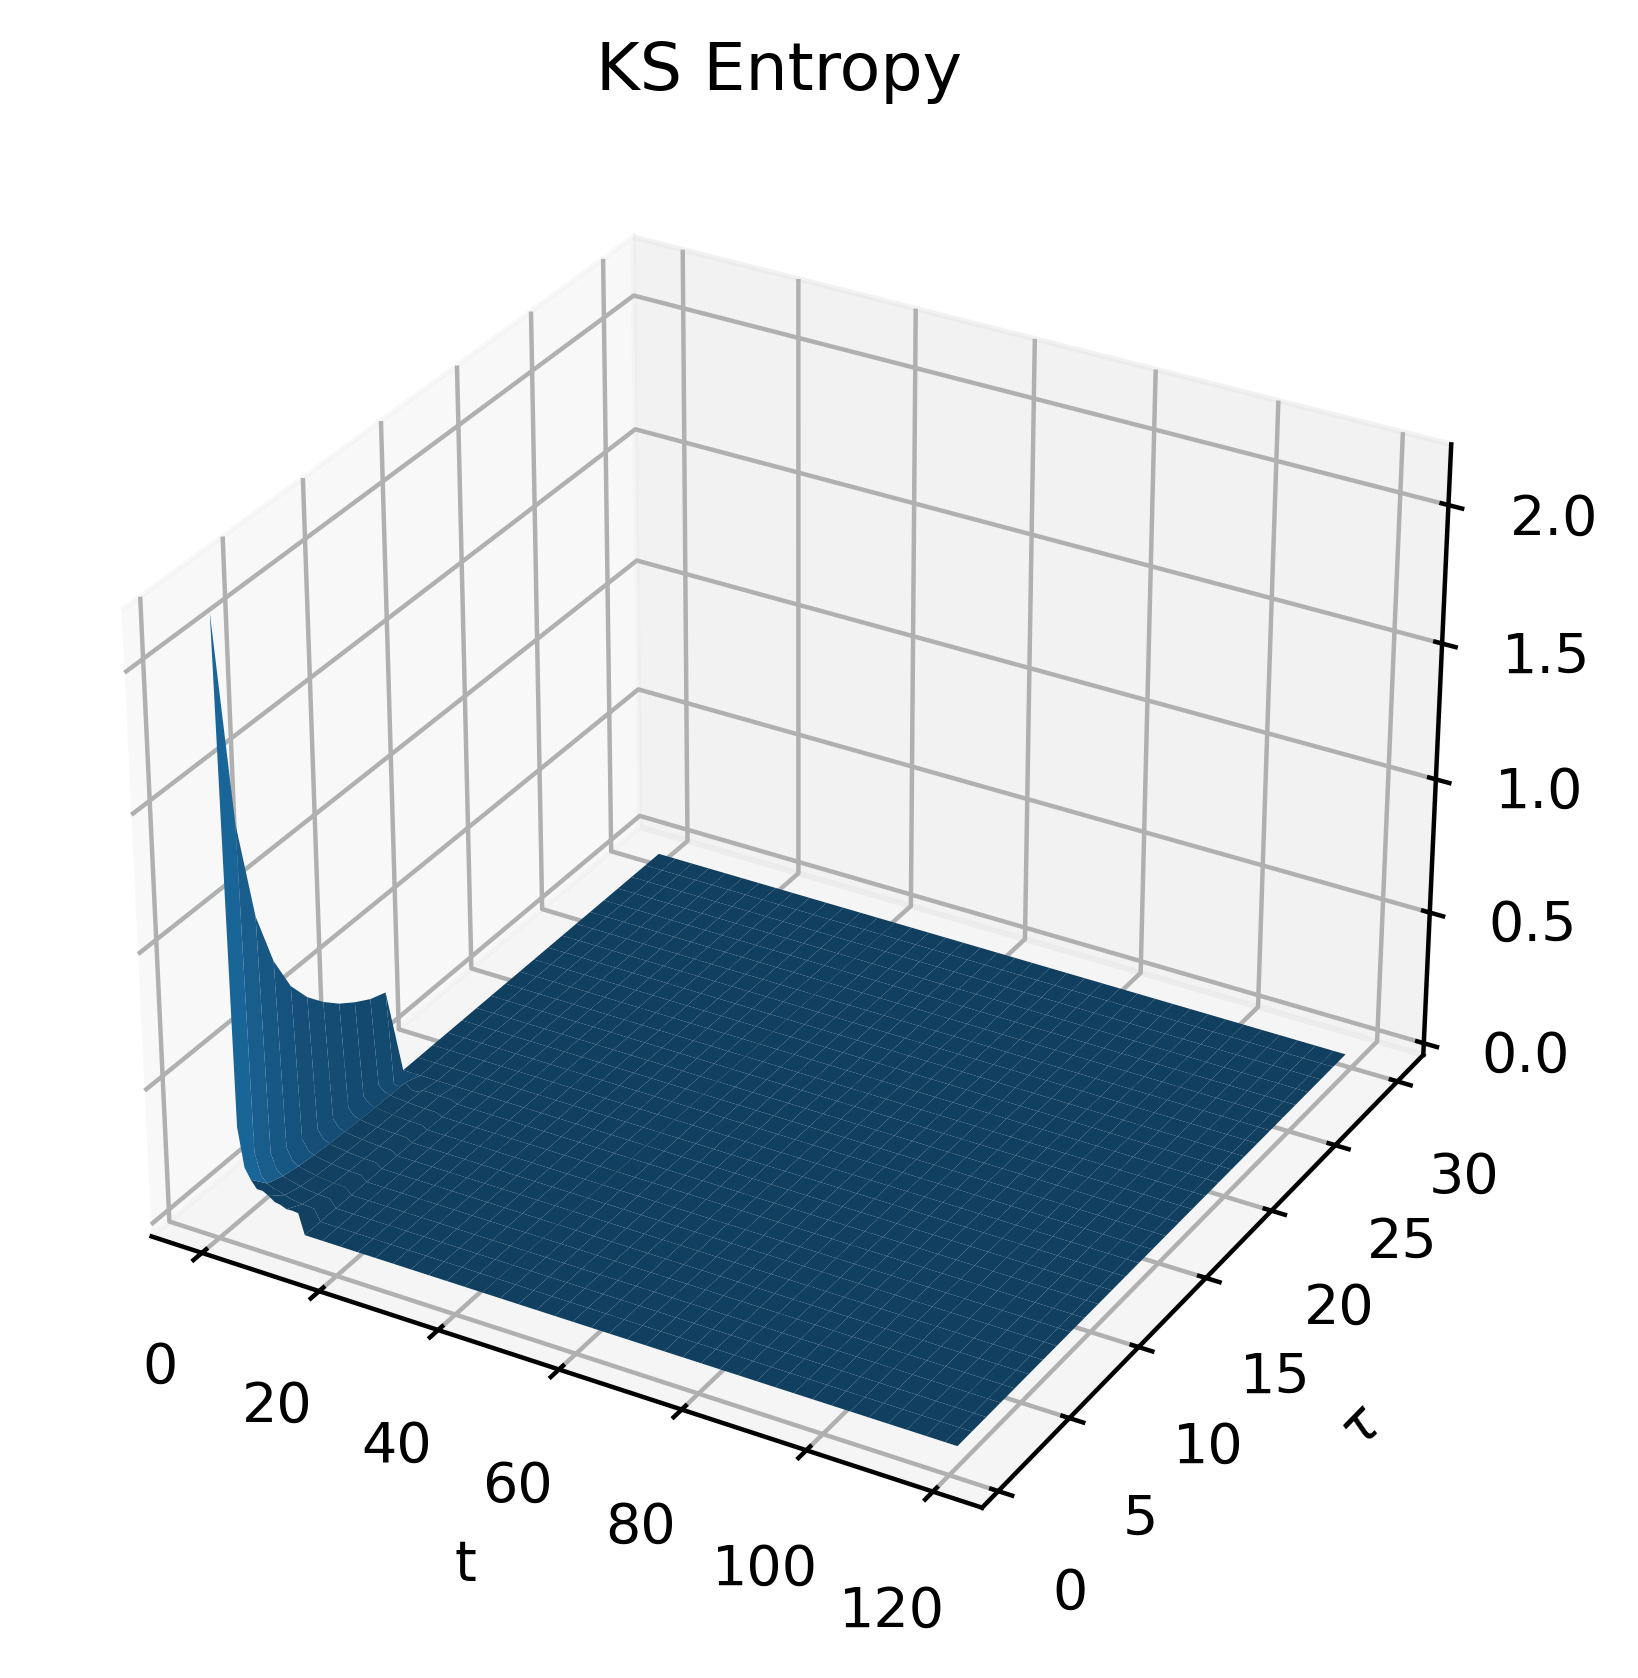

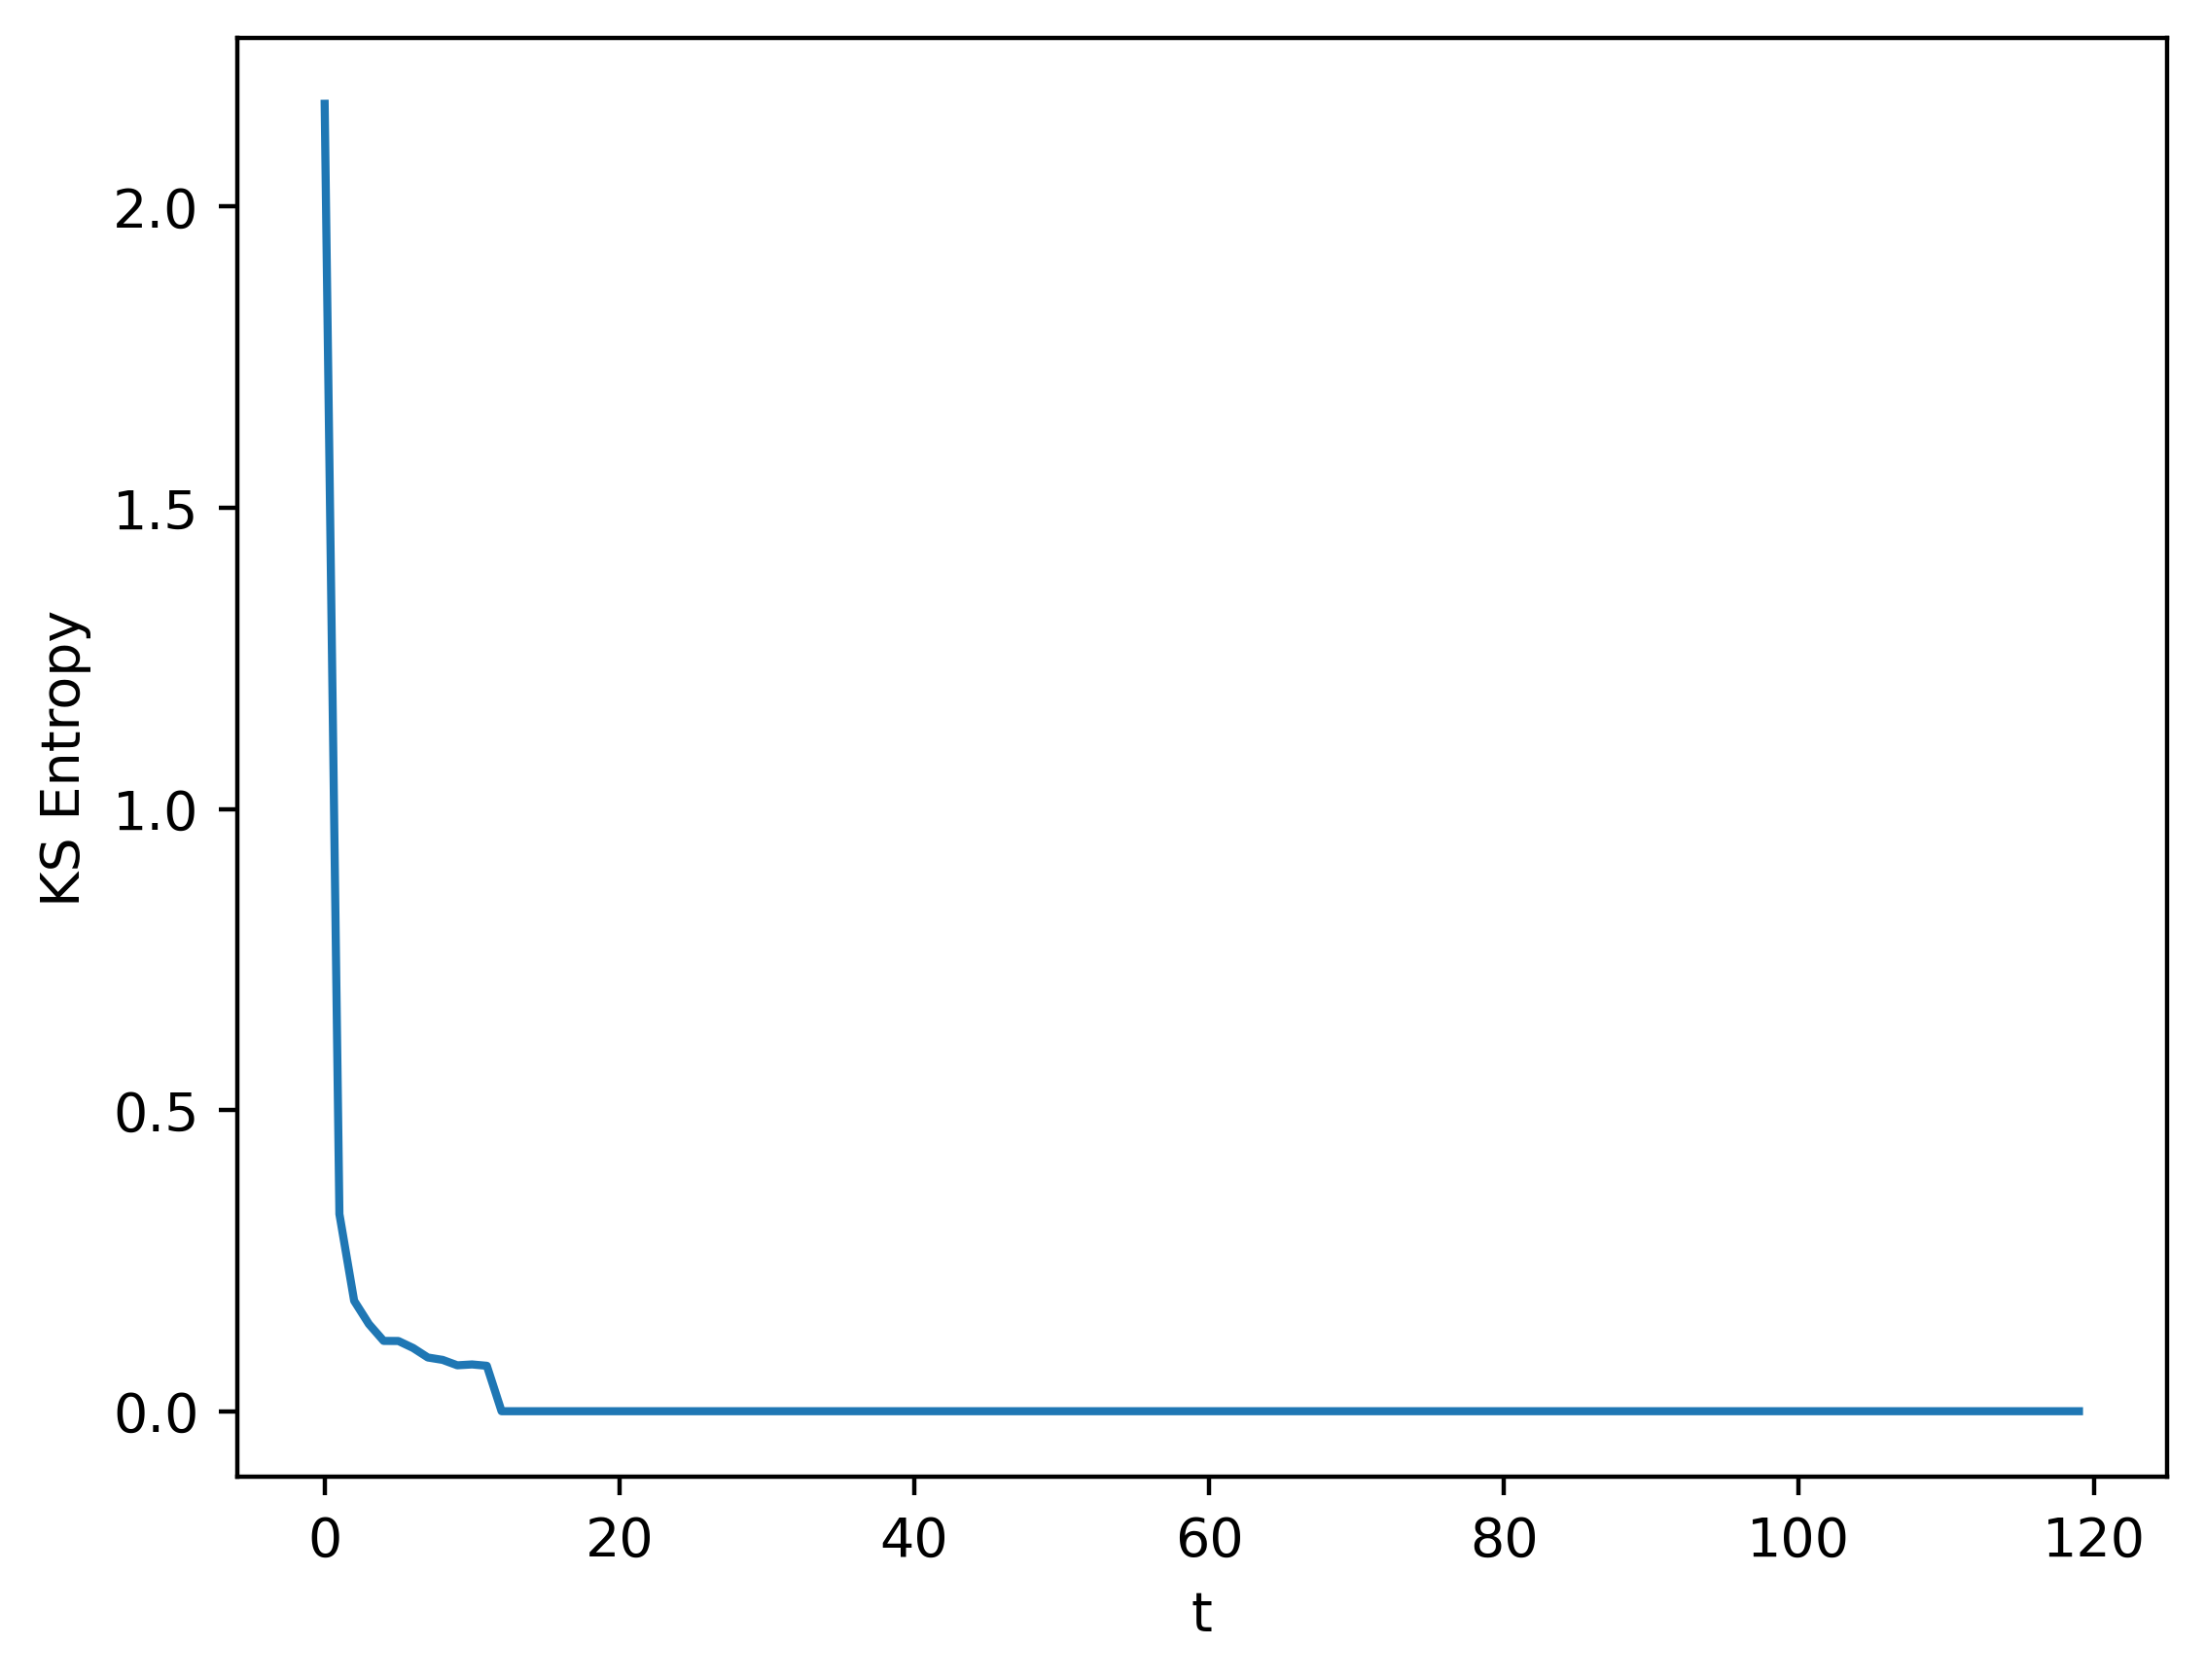

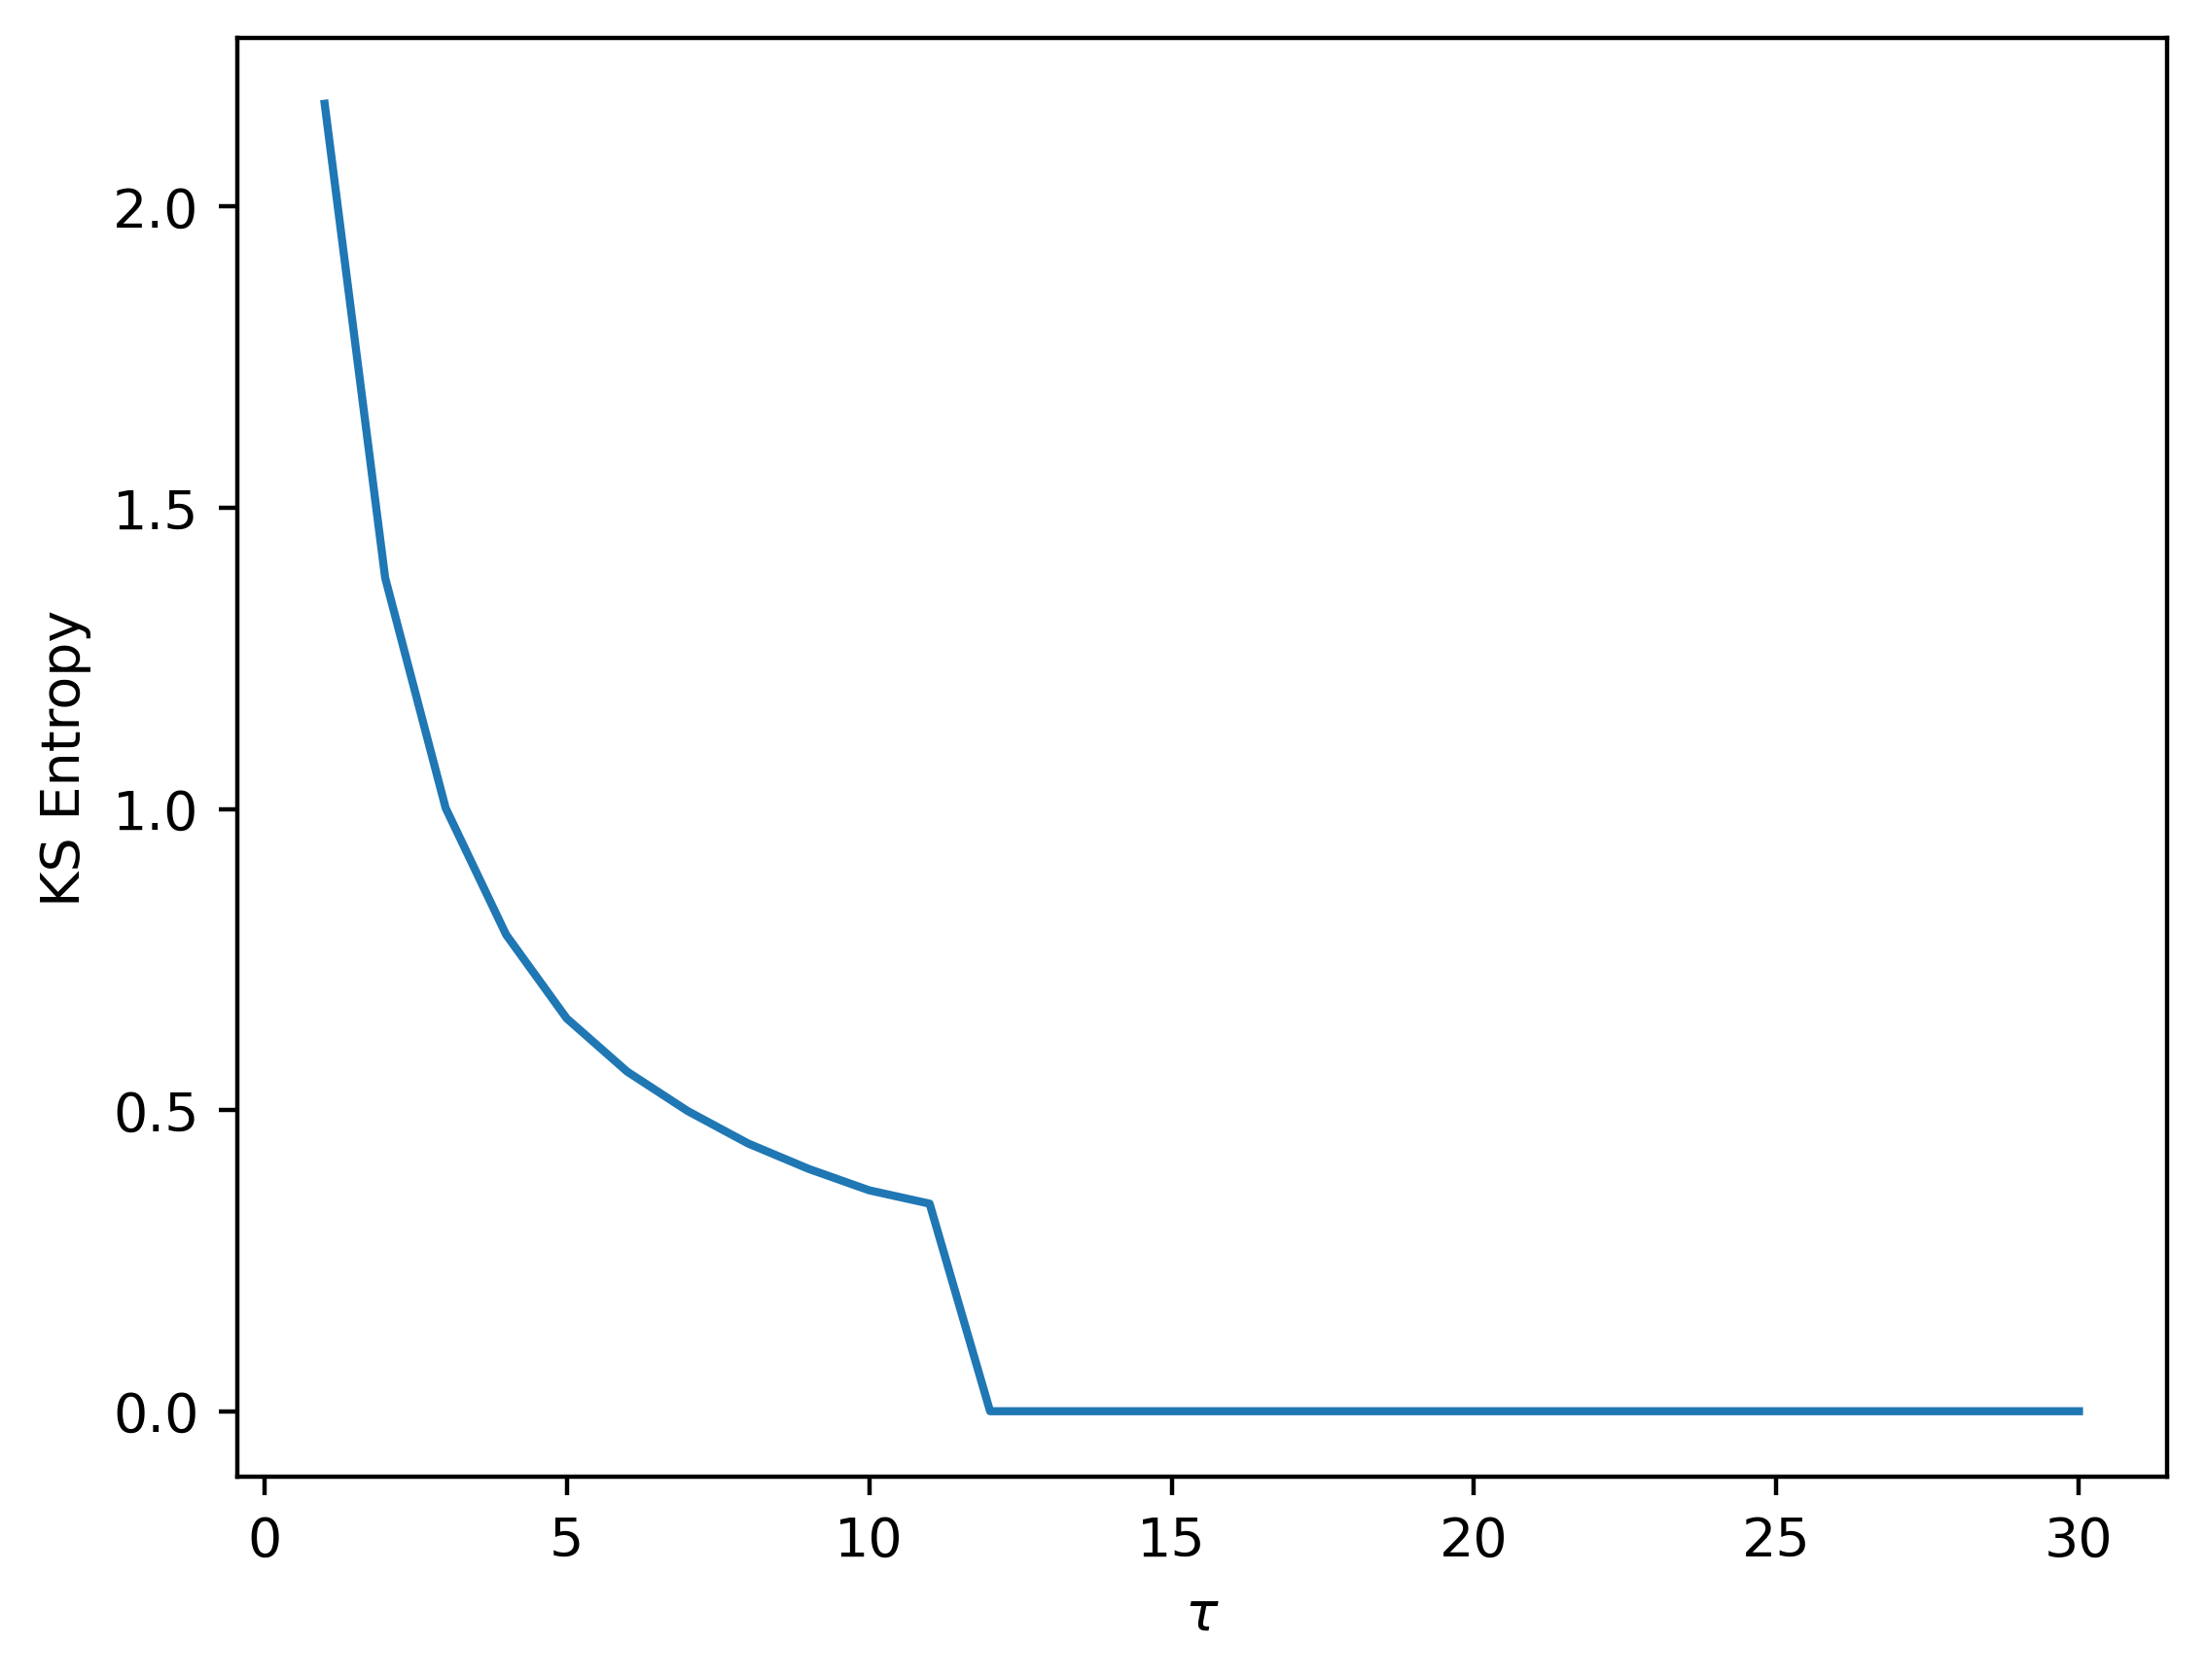

In [3]:
# KS熵矩阵可视化demo，相当于对一个三维矩阵可视化

KS_matrix = np.load('/nfs/xuhan/xyh/results/KS_entropy/arc_easy_true/0/att.key.l0.317.npy')
t = np.arange(np.shape(KS_matrix)[0])
tau = np.arange(np.shape(KS_matrix)[1])+1
t, tau = np.meshgrid(t, tau, indexing='ij')
KS_entropy = KS_matrix

fig = plt.figure(dpi=400)
ax = fig.add_subplot(111, projection='3d')
# cmap = plt.get_cmap('viridis')
# norm = plt.Normalize(KS_entropy.min(), KS_entropy.max())
# colors = cmap(norm(KS_entropy))
ax.plot_surface(t, tau, KS_entropy)

# 三维可视化
ax.set_title('KS Entropy')
ax.set_xlabel('t')
ax.set_ylabel('$\\tau$')
# ax.view_init(azim=-135)
plt.show()

# 沿t轴二维可视化
t = np.arange(np.shape(KS_matrix)[0])
KS_entropy = KS_matrix
plt.figure(dpi=400)
plt.plot(t, KS_matrix[:, 0])
plt.xlabel('t')
plt.ylabel('KS Entropy')
plt.show()

# 沿$\\tau$轴二维可视化
tau = np.arange(np.shape(KS_matrix)[1])+1
KS_entropy = KS_matrix
plt.figure(dpi=400)
plt.plot(tau, KS_matrix[0, :])
plt.xlabel('$\\tau$')
plt.ylabel('KS Entropy')
plt.show()


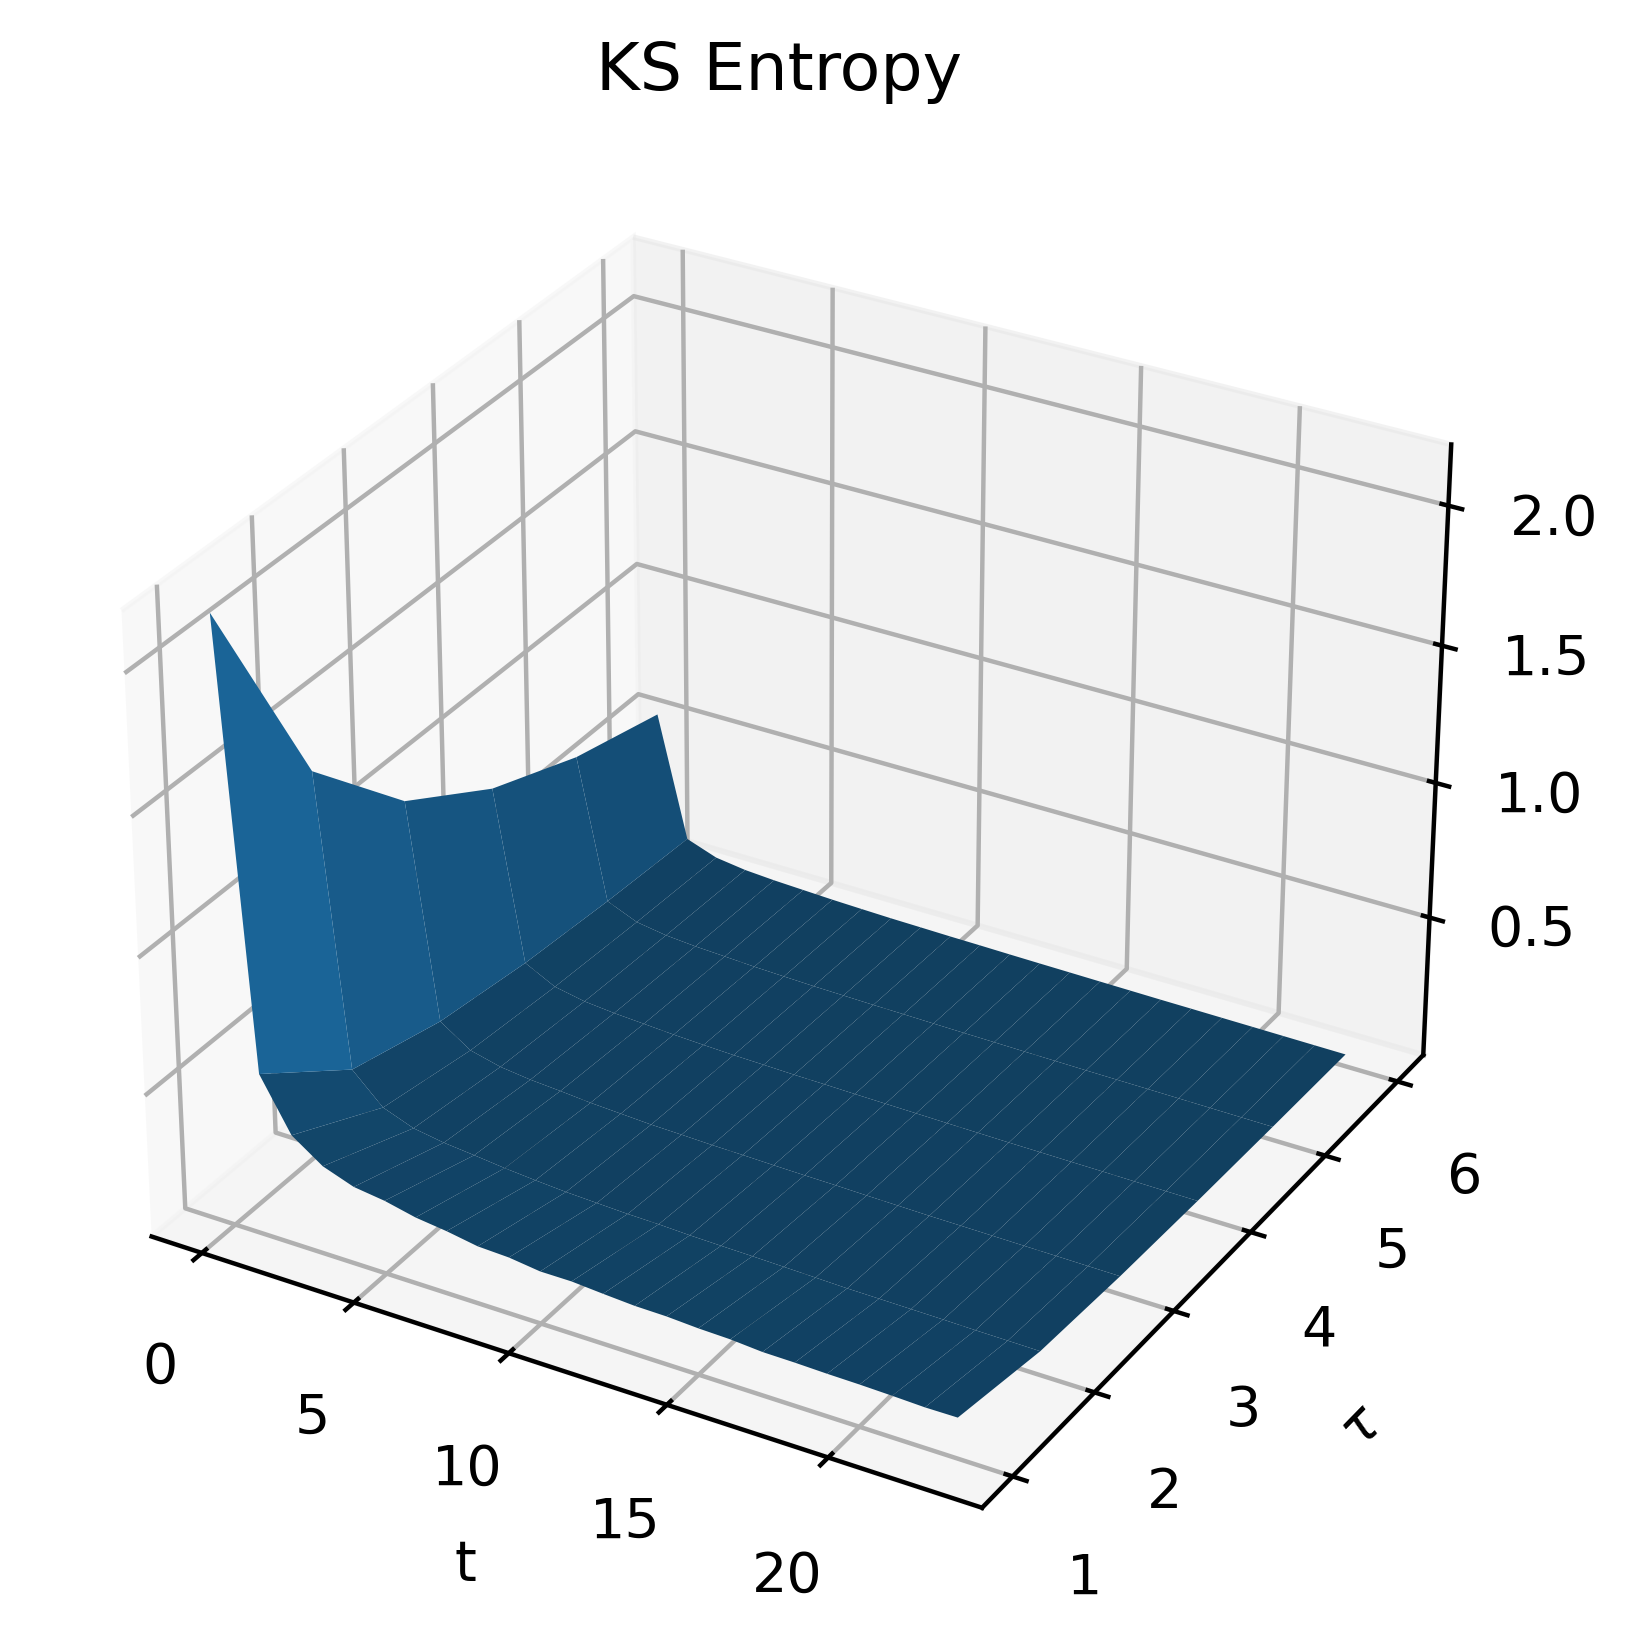

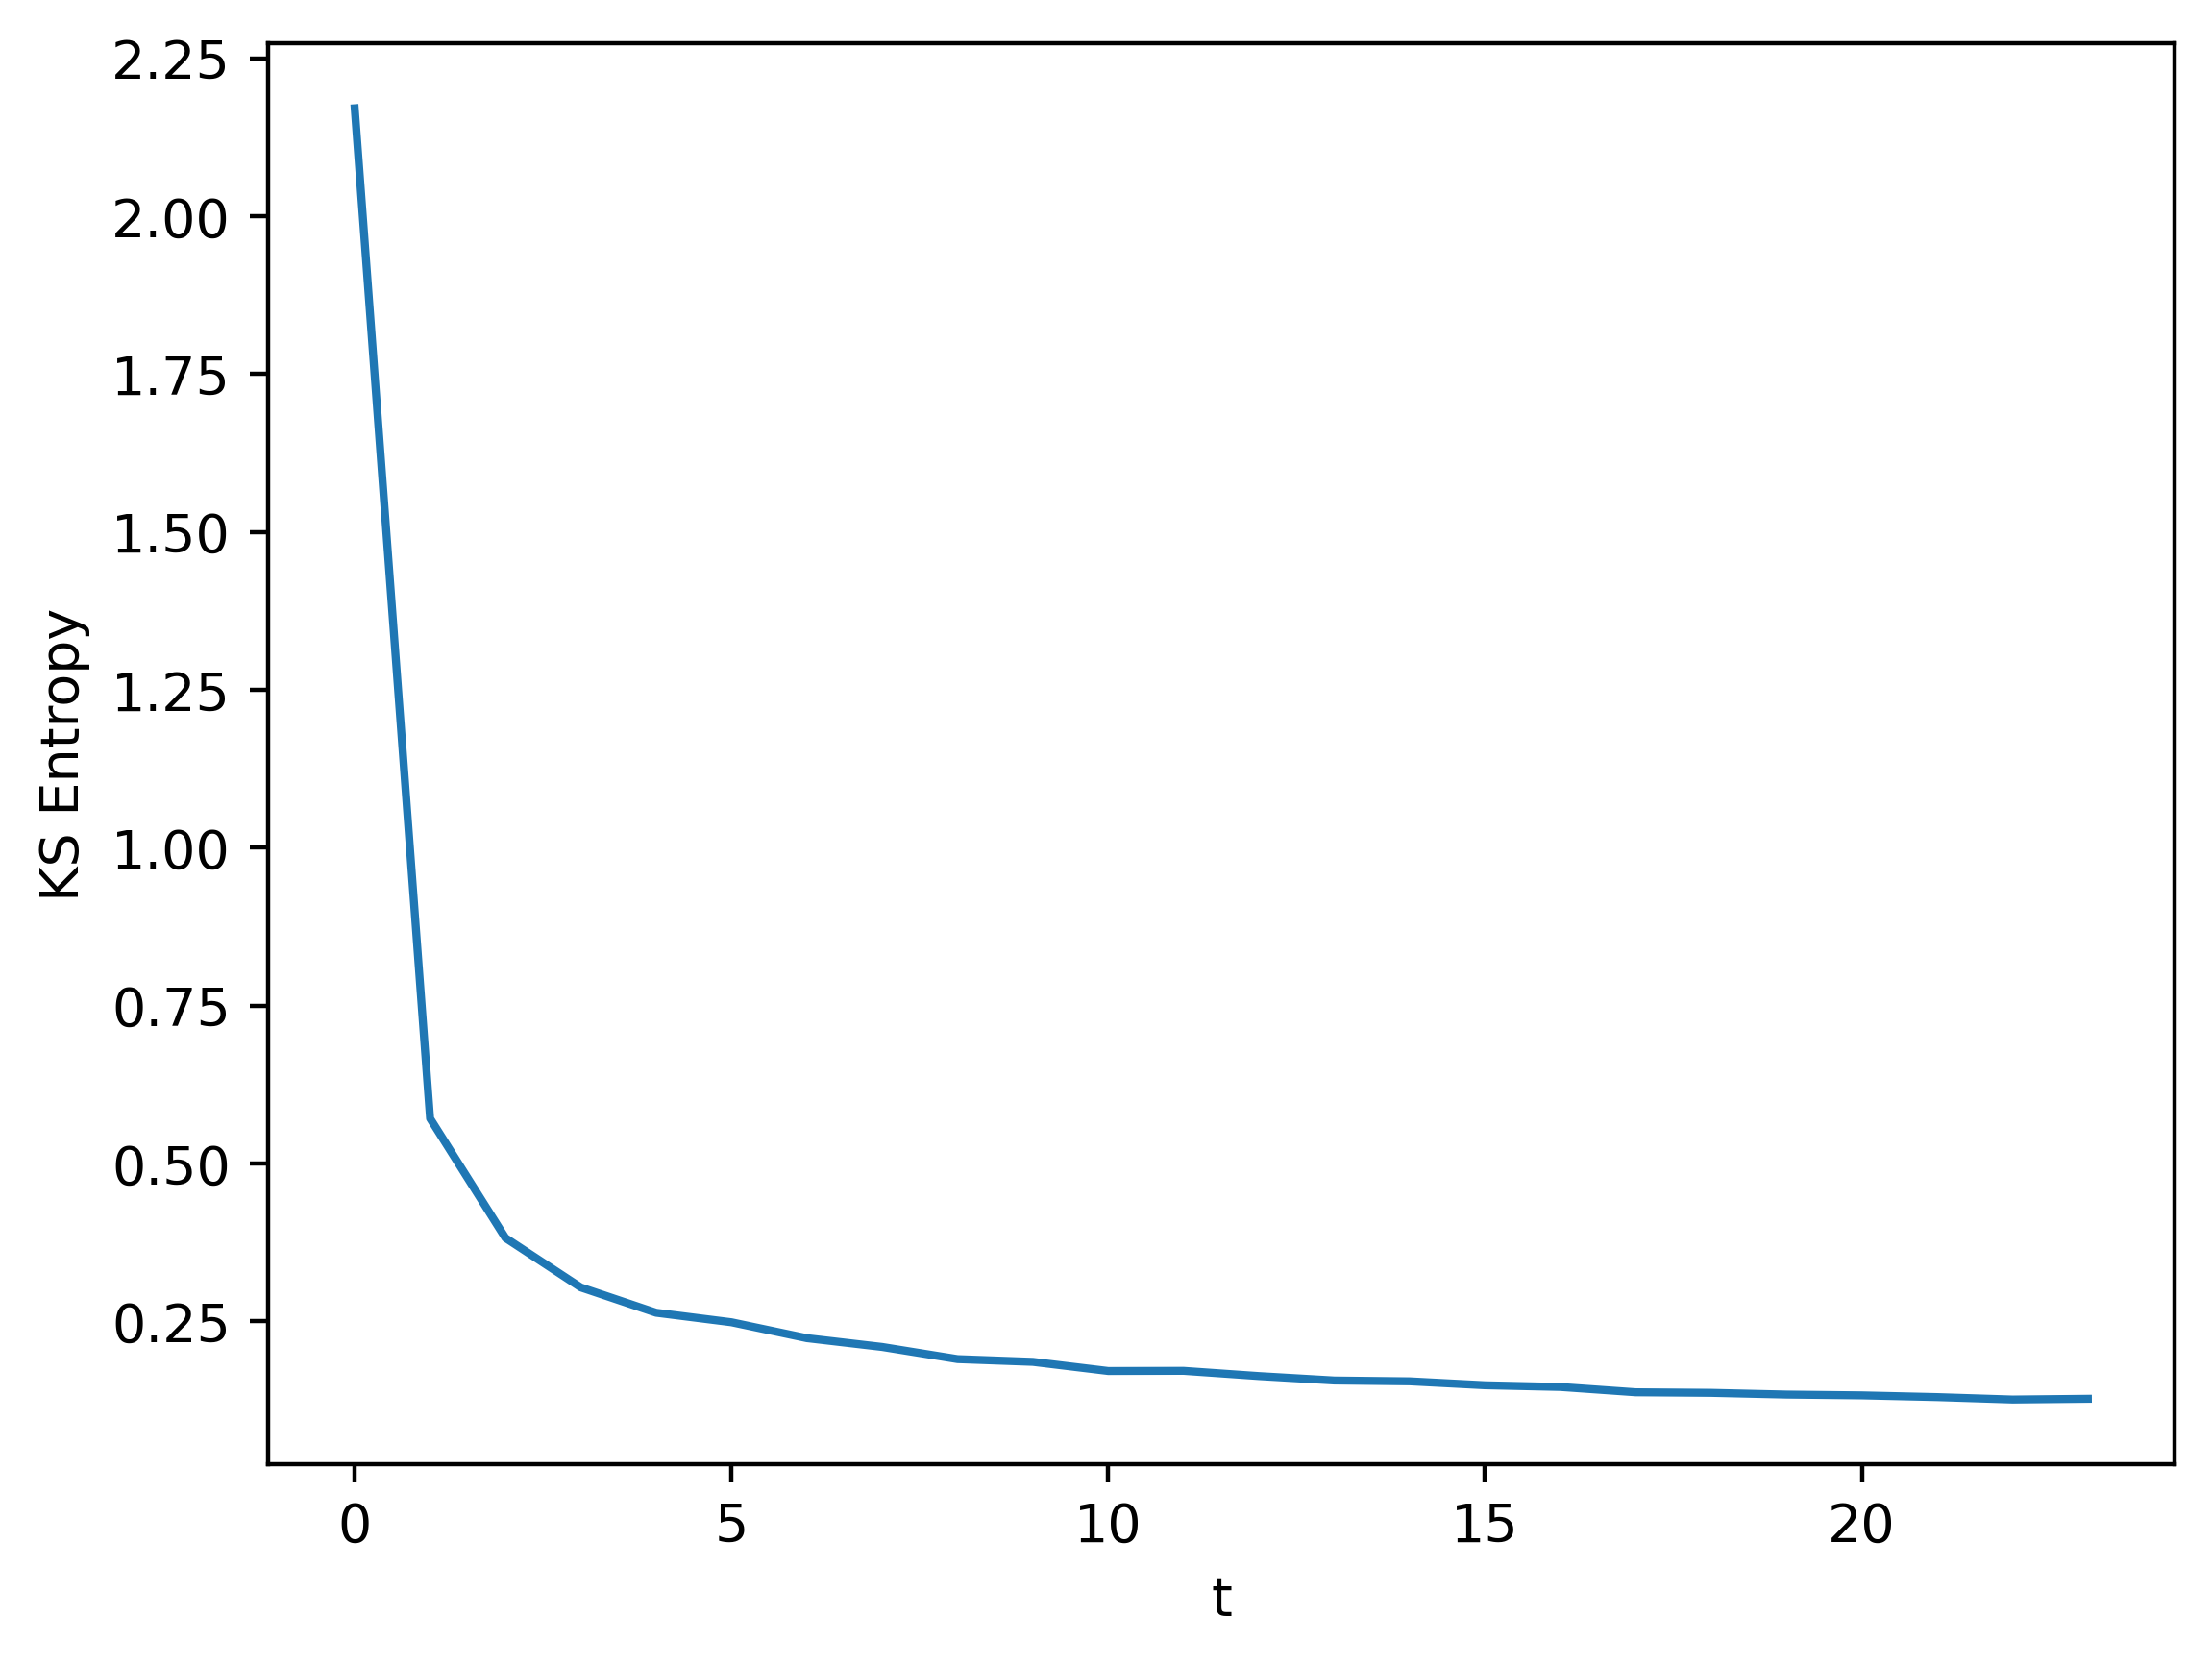

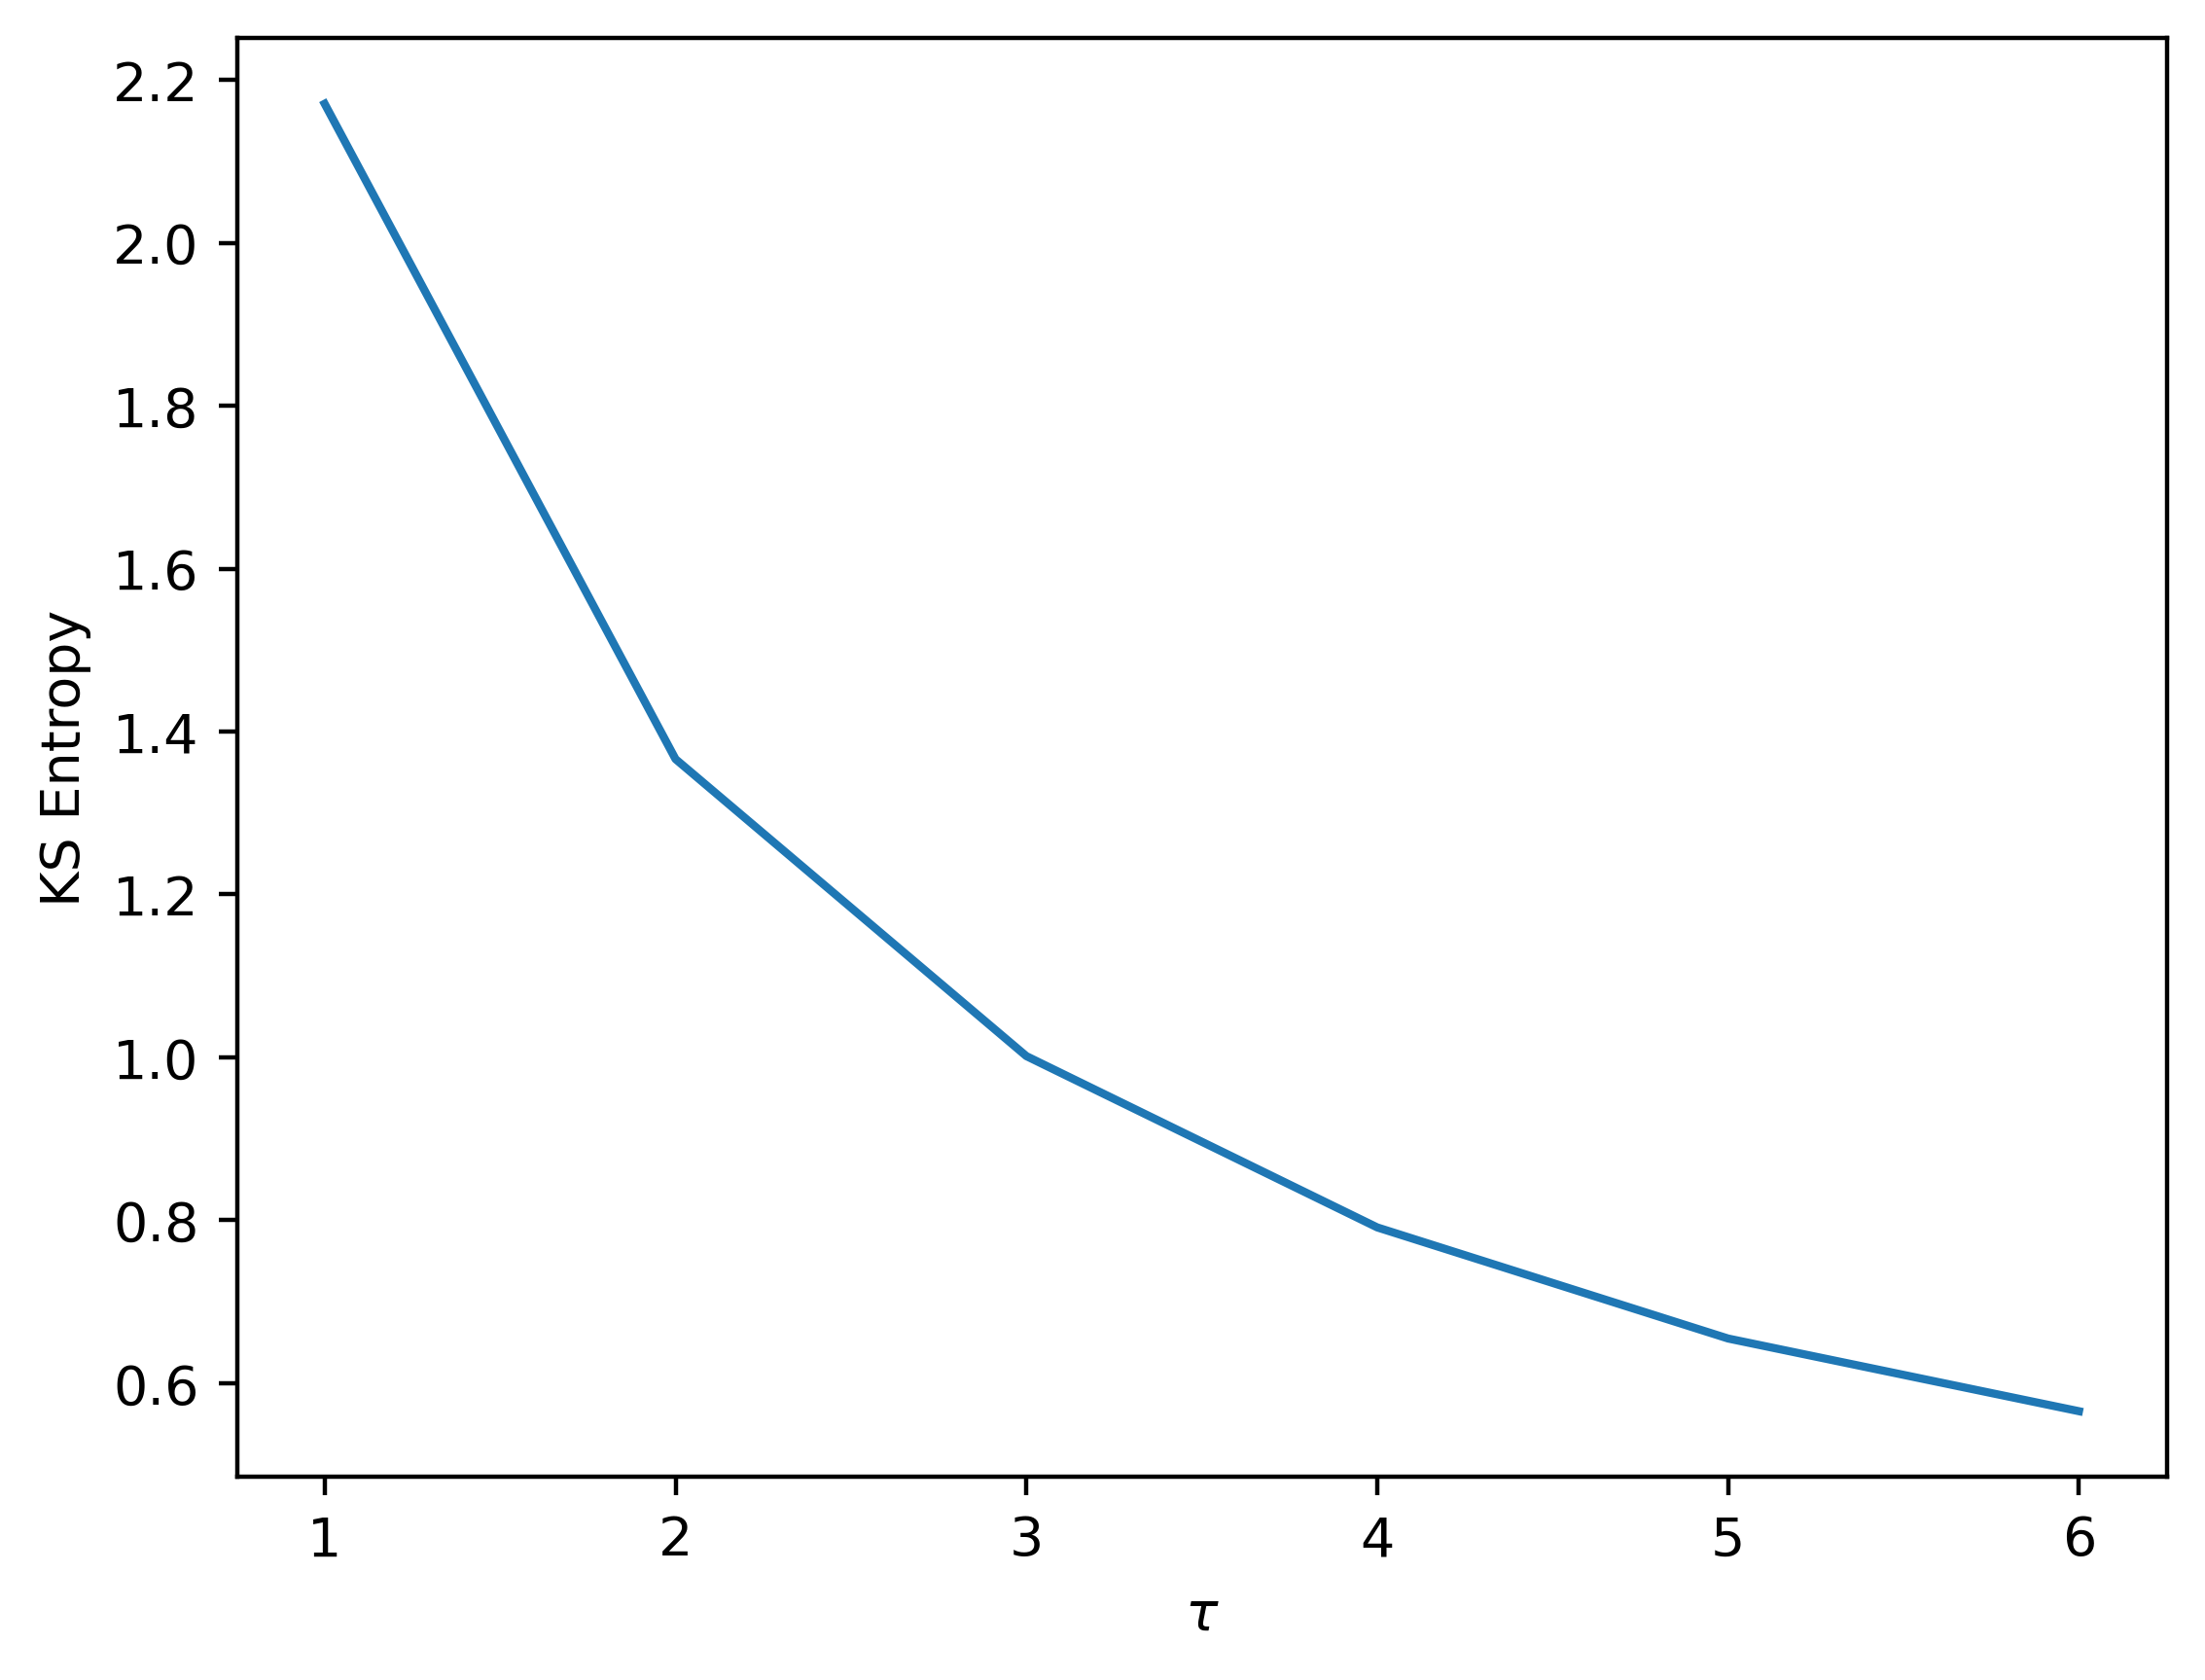

In [4]:
# KS熵矩阵可视化demo，相当于对一个三维矩阵可视化

KS_matrix = np.load('/nfs/xuhan/xyh/results/KS_entropy/winogrande_true/0/att.key.l0.0.207.npy')
t = np.arange(np.shape(KS_matrix)[0])
tau = np.arange(np.shape(KS_matrix)[1])+1
t, tau = np.meshgrid(t, tau, indexing='ij')
KS_entropy = KS_matrix

fig = plt.figure(dpi=400)
ax = fig.add_subplot(111, projection='3d')
# cmap = plt.get_cmap('viridis')
# norm = plt.Normalize(KS_entropy.min(), KS_entropy.max())
# colors = cmap(norm(KS_entropy))
ax.plot_surface(t, tau, KS_entropy)

# 三维可视化
ax.set_title('KS Entropy')
ax.set_xlabel('t')
ax.set_ylabel('$\\tau$')
# ax.view_init(azim=-135)
plt.show()

# 沿t轴二维可视化
t = np.arange(np.shape(KS_matrix)[0])
KS_entropy = KS_matrix
plt.figure(dpi=400)
plt.plot(t, KS_matrix[:, 0])
plt.xlabel('t')
plt.ylabel('KS Entropy')
plt.show()

# 沿$\\tau$轴二维可视化
tau = np.arange(np.shape(KS_matrix)[1])+1
KS_entropy = KS_matrix
plt.figure(dpi=400)
plt.plot(tau, KS_matrix[0, :])
plt.xlabel('$\\tau$')
plt.ylabel('KS Entropy')
plt.show()
